In [1]:
# !wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Musical_Instruments_5.json.gz
import os 
import json

from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity

from snowflake.snowpark import Session

import matplotlib.pyplot as plt
import seaborn as sns

## Connect to Snowflake / Snowpark Session

In [2]:
#Very easy to connect to your snowflake account

def get_token():
    with open('/snowflake/session/token', 'r') as f:
        return f.read()

connection_params = {
    'host': os.environ['SNOWFLAKE_HOST'],
    'port': os.environ['SNOWFLAKE_PORT'],
    'protocol': 'https',
    'account': os.environ['SNOWFLAKE_ACCOUNT'],
    'authenticator': 'oauth',
    'token': get_token(),
    'role': 'SERVICESNOW_USER_ROLE',
    'warehouse': 'MADKINS',
    'database': 'TOPIC_MODELING',
    'schema': 'PROD'
}

session = Session.builder.configs(connection_params).create()
session

In [3]:
session.get_current_warehouse(), session.get_current_role(), session.get_current_database(), session.get_current_schema()

('"MADKINS"', '"SERVICESNOW_USER_ROLE"', '"TOPIC_MODELING"', '"PROD"')

## Visualize our data

In [4]:
query = '''

    SELECT
        *
    FROM
        MUSIC_STORE_REVIEWS
    LIMIT 5
    
'''
df = session.sql(query).to_pandas()
df.head()

DATE                        PRODUCT  \
0 2023-06-01    Harmony G10 Electric Guitar   
1 2023-05-29       Melody M5000 Grand Piano   
2 2023-05-25           Rhythm R200 Drum Set   
3 2023-05-20  Serenade S700 Acoustic Guitar   
4 2023-05-18         Cadence C1500 Keyboard   

                                              REVIEW  RATING  
0  I am amazed by the sound quality of this guita...       5  
1  The keys on this piano feel a bit stiff, but t...       3  
2  I've been playing drums for years, and this dr...       5  
3  I'm not impressed with this guitar. The tone i...       2  
4  This keyboard is great for beginners. It has a...       3

## Load our NLP model

In [5]:
#Pre-run this guy
model_gpu = SentenceTransformer('all-mpnet-base-v2', device='cuda')
model_cpu = SentenceTransformer('all-mpnet-base-v2', device="cpu")

<AxesSubplot: >

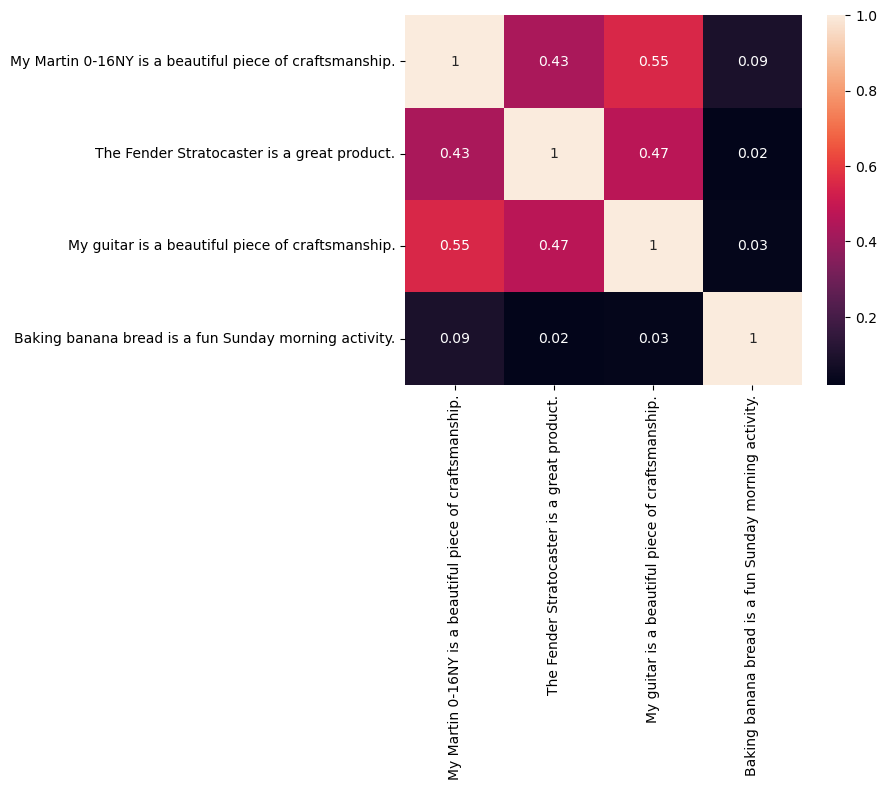

In [6]:
sentences = [
    "My Martin 0-16NY is a beautiful piece of craftsmanship.",
    "The Fender Stratocaster is a great product.",
    "My guitar is a beautiful piece of craftsmanship.",
    "Baking banana bread is a fun Sunday morning activity."
]

embeddings = model_gpu.encode(sentences)
similarities = cosine_similarity(embeddings).round(2)

similarities_df = pd.DataFrame(similarities)
similarities_df.columns = sentences
similarities_df.index = sentences

sns.heatmap(similarities_df, annot=True)

The embeddings from the baseline model suggest that these sentences are only somewhat similar, as the cosine similarity of just a bit over 0.5. In fact, we'd probably like for our model to think that all of the first three sentences are quite similar, as they all refer to guitars being of high quality. Fine-tuning on data relevant to our use case can help us improve the results.

Below, we fine-tune our model with a few examples to help it learn that a Martin-016NY is a type of guitar and that Fender is a guitar brand. We assign loose similarity scores as the `label` field to help teach the model which sentences are similar and which are dissimilar.

## Setting up the Training Data

In [7]:
# We'd use more examples in the real-world scenario.

train_examples = [
    InputExample(
        texts=["My Martin 0-16NY is a beautiful piece of craftsmanship.", "My guitar is a beautiful piece of craftsmanship."], label=0.95
    ),
    InputExample(
        texts=["My Martin 0-16NY is a beautiful piece of craftsmanship.", "James walked quickly through the forest."], label=0.1
    ),
    InputExample(
        texts=["When I played with a Martin 0-16NY every chord sounded perfect", "Sarah played her favorite songs on her guitar"], label=0.8
    ),
    InputExample(
        texts=["Fender has been making guitars for decades.", "Guitar-making has a rich history spanning decades."], label=0.8
    ),
    InputExample(
        texts=["Baking is a great way to relax.", "Guitar is an important instrument for rock and roll bands"], label=0.1
    ),
]

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)
train_loss = losses.CosineSimilarityLoss(model_cpu)

Let's fine-tune using the CPU-based model first, to get a sense of speed.

In [8]:
%%time

model_cpu = SentenceTransformer('all-mpnet-base-v2', device="cpu")
train_loss = losses.CosineSimilarityLoss(model_cpu)
model_cpu.fit(train_objectives=[(train_dataloader, train_loss)], epochs=15, warmup_steps=100)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 2min 41s, sys: 5.99 s, total: 2min 47s
Wall time: 8.44 s


That took about 10-11 seconds on an
. Let's see how long it takes when we use an NVIIDA A100 GPU.

In [9]:
%%time

model_gpu = SentenceTransformer('all-mpnet-base-v2', device='cuda')
train_loss = losses.CosineSimilarityLoss(model_gpu)
model_gpu.fit(train_objectives=[(train_dataloader, train_loss)], epochs=15, warmup_steps=100)

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 2.7 s, sys: 264 ms, total: 2.97 s
Wall time: 1.93 s


Less than 1.5 seconds. Using the A100 GPU brought us from about 1.8 iteration per second to about 16 iterations per second.

Let's see how our fine-tuning changed the embeddings generated by the model.

<AxesSubplot: title={'center': 'Similarity Scores from the Fine-Tuned Model'}>

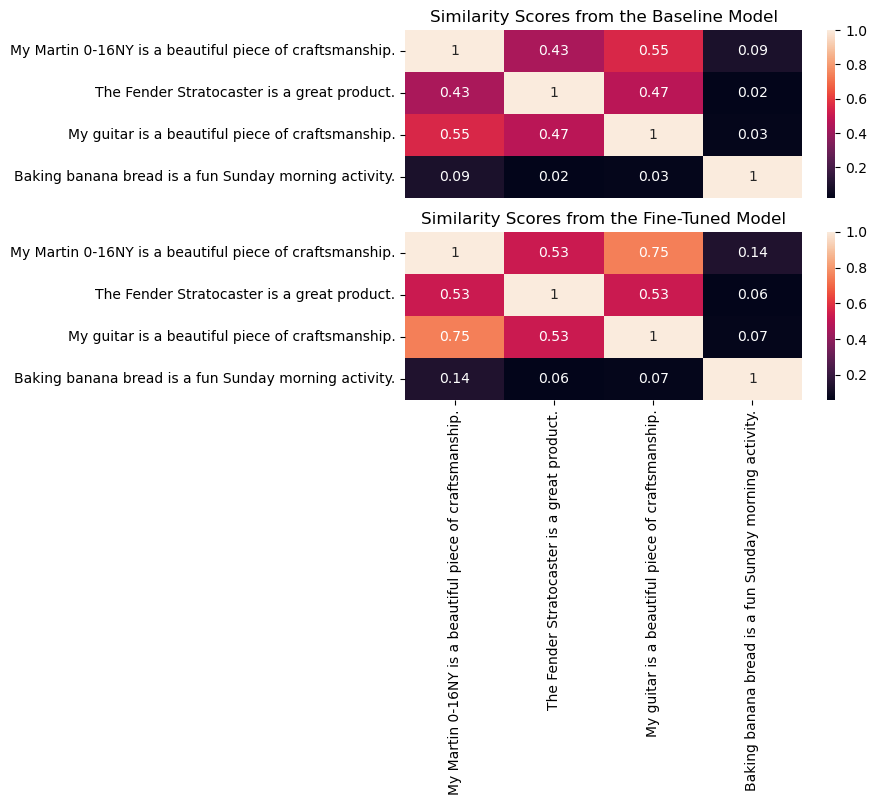

In [10]:
new_embeddings = model_gpu.encode(sentences)
new_similarities = cosine_similarity(new_embeddings).round(2)

new_similarities_df = pd.DataFrame(new_similarities)
new_similarities_df.columns = sentences
new_similarities_df.index = sentences

fig, axes = plt.subplots(2, 1)

axes[0].set_title("Similarity Scores from the Baseline Model")
axes[1].set_title("Similarity Scores from the Fine-Tuned Model")
sns.heatmap(similarities_df, annot=True, ax=axes[0], xticklabels="")
sns.heatmap(new_similarities_df, annot=True, ax=axes[1])

# Snowpark Containers Job
We kick off a job to do this at scale and save the model to a stage

In [11]:
query = '''

    SHOW COMPUTE POOLS LIKE 'NVIDIA_A10Gx4';
    
'''

pd.DataFrame(session.sql(query).collect())

name   state  min_nodes  max_nodes instance_family  num_services  \
0  NVIDIA_A10GX4  ACTIVE          1          1           GPU_7             1   

   auto_suspend_secs auto_resume  active_nodes  idle_nodes  \
0                  0        true             1           0   

                        created_on                       resumed_on  \
0 2023-06-02 20:44:57.867000-07:00 2023-06-07 10:05:06.796000-07:00   

                        updated_on                  owner comment  
0 2023-06-07 11:32:45.714000-07:00  SERVICESNOW_USER_ROLE    None

In [18]:
query = '''

    EXECUTE SERVICE WITH
        COMPUTE_POOL = NVIDIA_A10Gx4
        SPEC = @tm_stage/transformers_train_manifest.yaml;

'''

session.sql(query).collect()

[Row(status='Execution submitted successfully as 01acd0ad-0001-a3de-001f-900700407552.')]

In [19]:
query = '''

    CALL SYSTEM$GET_JOB_LOGS('01acd0ad-0001-a3de-001f-900700407552', 'nvidia-train',1000);

'''

session.sql(query).collect()

SnowparkSQLException: (1304): 01acd0ad-0001-a5ce-001f-90070040856e: 000005 (XX000): Failed to get logs for container: nvidia-train. Error message: Waiting to start container, Container Status: PENDING, Container Image: sfengineering-servicesnow.registry.snowflakecomputing.com/topic_modeling/prod/tm/rapidsai:22.12-cuda11.5-base-ubuntu20.04-py3.8

# Generating embeddings for larger dataset with Triton and the model

Let's launch our Triton service to use our model to generate embeddings for all of our documents

In [20]:
query = '''
    
    CREATE SERVICE topic_modeling
        MIN_INSTANCES = 1
        MAX_INSTANCES = 1
        COMPUTE_POOL = NVIDIA_A10Gx4
        SPEC = '@tm_stage/manifest.yaml';

'''
session.sql(query).collect()

SnowparkSQLException: (1304): 01acd0ad-0001-a5ce-001f-900700408576: 002002 (42710): SQL compilation error:
Object 'TOPIC_MODELING' already exists.

In [16]:
query = '''
    
    CALL SYSTEM$GET_SERVICE_STATUS('TOPIC_MODELING.PROD.TOPIC_MODELING')

'''
session.sql(query).collect()

[Row(SYSTEM$GET_SERVICE_STATUS='[{"status":"READY","message":"Running","containerName":"tritonclient","instanceId":"0","serviceName":"TOPIC_MODELING","image":"sfengineering-servicesnow.registry.snowflakecomputing.com/topic_modeling/prod/tm/tritonserver:22.12-py3-sdk","restartCount":0},{"status":"READY","message":"Running","containerName":"tritonserver","instanceId":"0","serviceName":"TOPIC_MODELING","image":"sfengineering-servicesnow.registry.snowflakecomputing.com/topic_modeling/prod/tm/tritonserver:22.12-pyt-python-py3","restartCount":0},{"status":"READY","message":"Running","containerName":"nvidia-notebook","instanceId":"0","serviceName":"TOPIC_MODELING","image":"sfengineering-servicesnow.registry.snowflakecomputing.com/topic_modeling/prod/tm/rapidsai:22.12-cuda11.5-runtime-ubuntu20.04-py3.8","restartCount":0}]')]

In [21]:
query = '''
    
    CALL SYSTEM$GET_SERVICE_LOGS('TOPIC_MODELING.PROD.TOPIC_MODELING','0', 'tritonserver', 10000)

'''
session.sql(query).collect()

[Row(SYSTEM$GET_SERVICE_LOGS='I0607 18:32:50.673404 1 pinned_memory_manager.cc:240] Pinned memory pool is created at \'0x7f9ca8000000\' with size 268435456\nI0607 18:32:50.686016 1 cuda_memory_manager.cc:105] CUDA memory pool is created on device 0 with size 67108864\nI0607 18:32:50.686032 1 cuda_memory_manager.cc:105] CUDA memory pool is created on device 1 with size 67108864\nI0607 18:32:50.686036 1 cuda_memory_manager.cc:105] CUDA memory pool is created on device 2 with size 67108864\nI0607 18:32:50.686038 1 cuda_memory_manager.cc:105] CUDA memory pool is created on device 3 with size 67108864\nW0607 18:32:51.331343 1 server.cc:218] failed to enable peer access for some device pairs\nI0607 18:32:51.857269 1 model_lifecycle.cc:459] loading: topic_modeling:1\nI0607 18:32:56.422377 1 python_be.cc:1856] TRITONBACKEND_ModelInstanceInitialize: topic_modeling_0 (GPU device 0)\nI0607 18:33:08.014042 1 python_be.cc:1856] TRITONBACKEND_ModelInstanceInitialize: topic_modeling_1 (GPU device 1)\

In [38]:
query = '''

    CREATE OR REPLACE FUNCTION triton(n VARCHAR)
      RETURNS ARRAY
      SERVICE = topic_modeling
      ENDPOINT = 'tritonclient'
      MAX_BATCH_ROWS = 1000
      AS '/inference_topic_modeling'

'''
session.sql(query).collect()

[Row(status='Function TRITON successfully created.')]

In [40]:
query = '''

    SELECT
        triton(REVIWER_TEXT) as ok
    FROM
        "TOPIC_MODELING"."PROD"."TEST"

'''
session.sql(query).show()

------------------------------
|"OK"                        |
------------------------------
|[                           |
|  -0.04534609988331795,     |
|  0.0032540317624807358,    |
|  0.0006201941287145019,    |
|  -0.02006729319691658,     |
|  -0.022379916161298752,    |
|  -0.03180615231394768,     |
|  0.01646445319056511,      |
|  0.006004737224429846,     |
|  -0.05368446931242943,     |
|  -0.01197102852165699,     |
|  -0.04898388683795929,     |
|  0.07505200058221817,      |
|  -0.04900795593857765,     |
|  0.01377507671713829,      |
|  -0.024451972916722298,    |
|  -0.0442323163151741,      |
|  -0.007306003477424383,    |
|  0.04897494614124298,      |
|  -0.05941641703248024,     |
|  0.025340743362903595,     |
|  -0.013881376944482327,    |
|  -0.009875820018351078,    |
|  -0.05920969322323799,     |
|  -0.01045195572078228,     |
|  -0.010542141273617744,    |
|  0.0014471765607595444,    |
|  -0.008670894429087639,    |
|  0.024800799787044525,     |
|  -0.03

# Doing the Topic Modeling

With our embeddings and model saved, we can load them both and do our topic modeling

In [113]:
!mkdir -p /rapids/notebooks/topic-modeling/models-from-snowflake/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [114]:
q = """
get @sentencetransformer_model file:///rapids/notebooks/topic-modeling/models-from-snowflake/
"""
res = session.sql(q)
res.collect()

[Row(file='fine-tuned-model.tar.gz', size=405000688, status='DOWNLOADED', message='')]

In [8]:
cd /rapids/notebooks/topic-modeling/models-from-snowflake/
!tar -xvzf fine-tuned-model.tar.gz

In [118]:
from sentence_transformers import SentenceTransformer

reconstructed_model = SentenceTransformer("/rapids/notebooks/topic-modeling/models-from-snowflake/fine-tuned-model/")

In [ ]:
reconstructed_model

In [120]:
connection_parameters = {
    "account": config["SNOWFLAKE_ACCOUNT"],
    "user": config["SNOWFLAKE_USERNAME"],
    "password": config["SNOWFLAKE_PASSWORD"],
    "role": "rapids",  # optional
    "warehouse": "COMPUTE_WH",  # optional
    "database": "SFENGINEERING_SERVICESNOW_AWS_CUSTOMER_REVIEWS",  # optional
    "schema": "PROD",  # optional
}  

session = Session.builder.configs(connection_parameters).create()
session

In [128]:
q = """
SELECT *
FROM AWS_PRODUCT_REVIEWS
LIMIT 50000
"""
res = session.sql(q)
pdf = res.toPandas()
pdf.head()

DATETIME       REVIEWER_NAME  \
0 2015-01-05      "Joseph Diehl"   
1 2018-08-04               "TKD"   
2 2017-12-15              "Lucy"   
3 2017-12-12    "Rachel Hanover"   
4 2017-01-21  "Sherri Wilbourne"   

                                             SUMMARY STARS  \
0                                        "Fantastic"     5   
1  "Subpar quality, paint chips same day, not rub...     2   
2                                      "Three Stars"     3   
3                                        "Great Toy"     5   
4                                       "Five Stars"     5   

                                        REVIWER_TEXT VERIFIED  
0  "Fantastic, I wish they came out with this bac...     true  
1  "Not the quality we were expecting. The paint ...     true  
2                 "Ok but it chips off pretty fast!"     true  
3  "My friend's son loves it. A bit heavier than ...     true  
4                            "Great, fast shipping."     true

In [178]:
N = 10000

# remove empty reviews
pdf = pdf.loc[~pdf.REVIWER_TEXT.isnull()]

relevant = pdf.head(N)

docs = relevant.REVIWER_TEXT.tolist()[:N]

<Axes: >

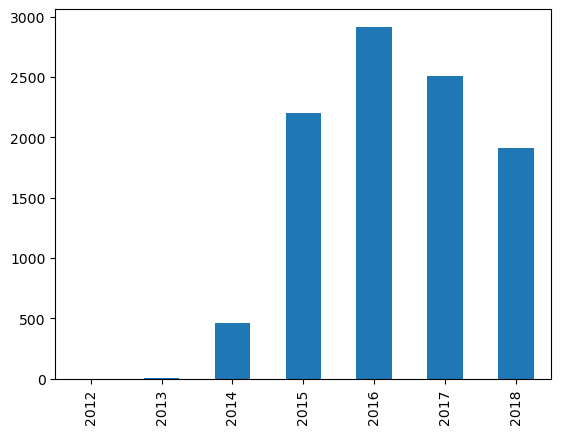

In [321]:
relevant.DATETIME.dt.year.value_counts().sort_index().plot(kind="bar")

In [189]:
reconstructed_model = SentenceTransformer("all-mpnet-base-v2")

In [190]:
%%time

embeddings = reconstructed_model.encode(
    sentences=docs,
    batch_size=32,
    show_progress_bar=True
)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

CPU times: user 43.9 s, sys: 1.42 s, total: 45.3 s
Wall time: 10.2 s


In [298]:
from bertopic import BERTopic
from cuml.cluster import HDBSCAN
from cuml.manifold import UMAP
from sklearn.feature_extraction.text import CountVectorizer

# Create instances of GPU-accelerated UMAP and HDBSCAN
umap_model = UMAP(n_components=5, n_neighbors=15, min_dist=0.0)
hdbscan_model = HDBSCAN(
    min_samples=10,
    min_cluster_size=50,
    gen_min_span_tree=True,
    prediction_data=True
)

vectorizer_model = CountVectorizer(stop_words="english")

# Pass the above models to be used in BERTopic
topic_model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    verbose=True,
    calculate_probabilities=True,
    vectorizer_model=vectorizer_model,
)
topics, probs = topic_model.fit_transform(docs, embeddings)

2023-05-19 20:58:20,598 - BERTopic - Reduced dimensionality
2023-05-19 20:58:20,719 - BERTopic - Clustered reduced embeddings


In [299]:
pd.Series(topics).value_counts()

-1     4491
 0      330
 1      277
 2      269
 3      266
 4      260
 5      258
 6      255
 7      218
 8      216
 9      206
 10     188
 11     179
 12     179
 13     163
 14     158
 15     157
 16     137
 17     135
 18     126
 19     119
 20     104
 21     103
 22      93
 23      78
 26      73
 25      73
 24      73
 27      72
 29      69
 28      69
 30      67
 32      66
 31      66
 33      64
 34      62
 35      59
 36      59
 37      58
 38      54
 39      51
dtype: int64

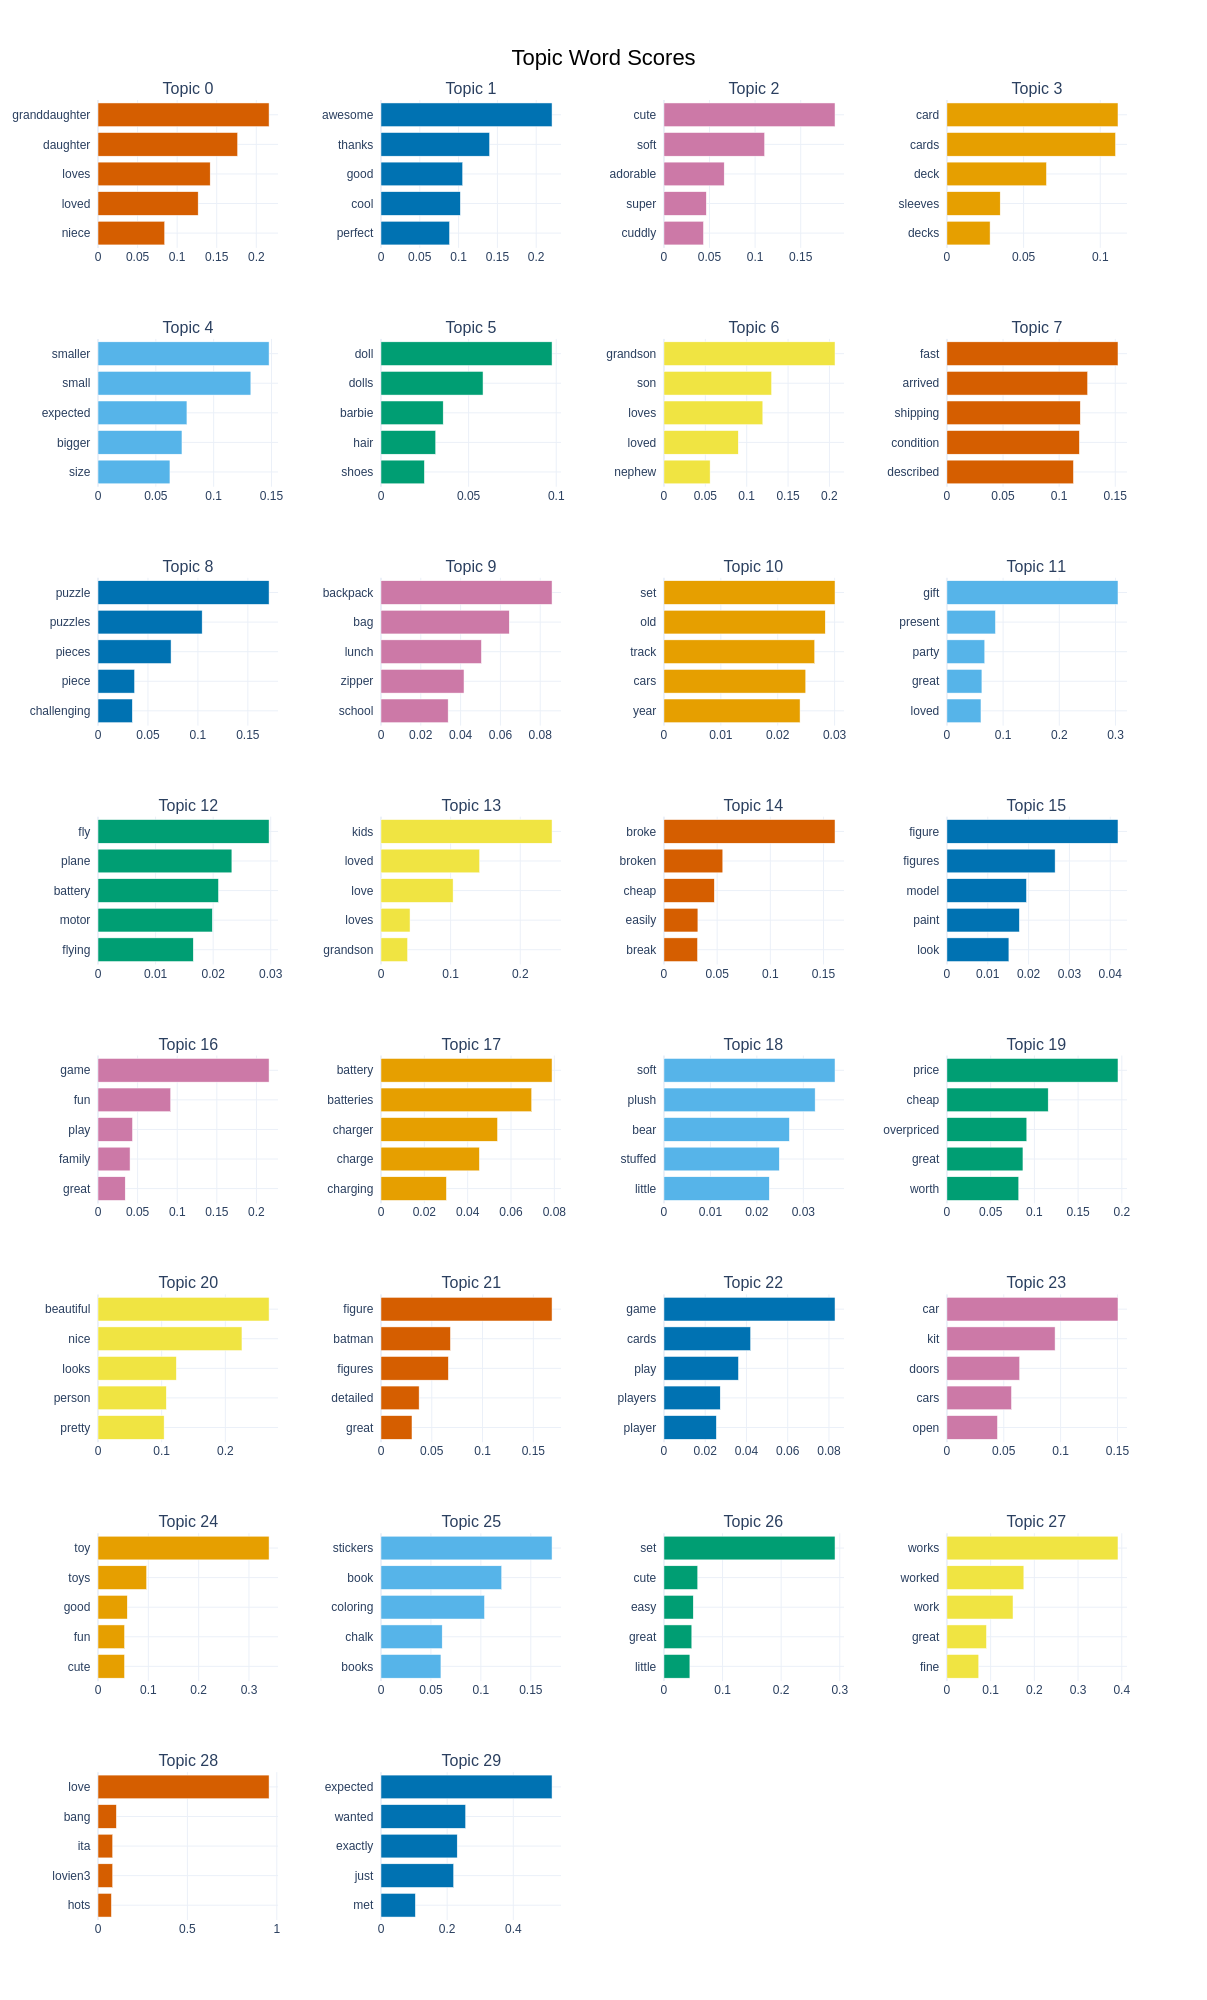

In [319]:
topic_model.visualize_barchart(top_n_topics=30)

In [301]:
# new_topics = topic_model.reduce_outliers(docs, topics, probabilities=probs, strategy="probabilities")
# topic_model.update_topics(docs, topics=new_topics)
# topic_model.visualize_barchart(top_n_topics=25)

100%|██████████| 39/39 [00:00<00:00, 188.54it/s]


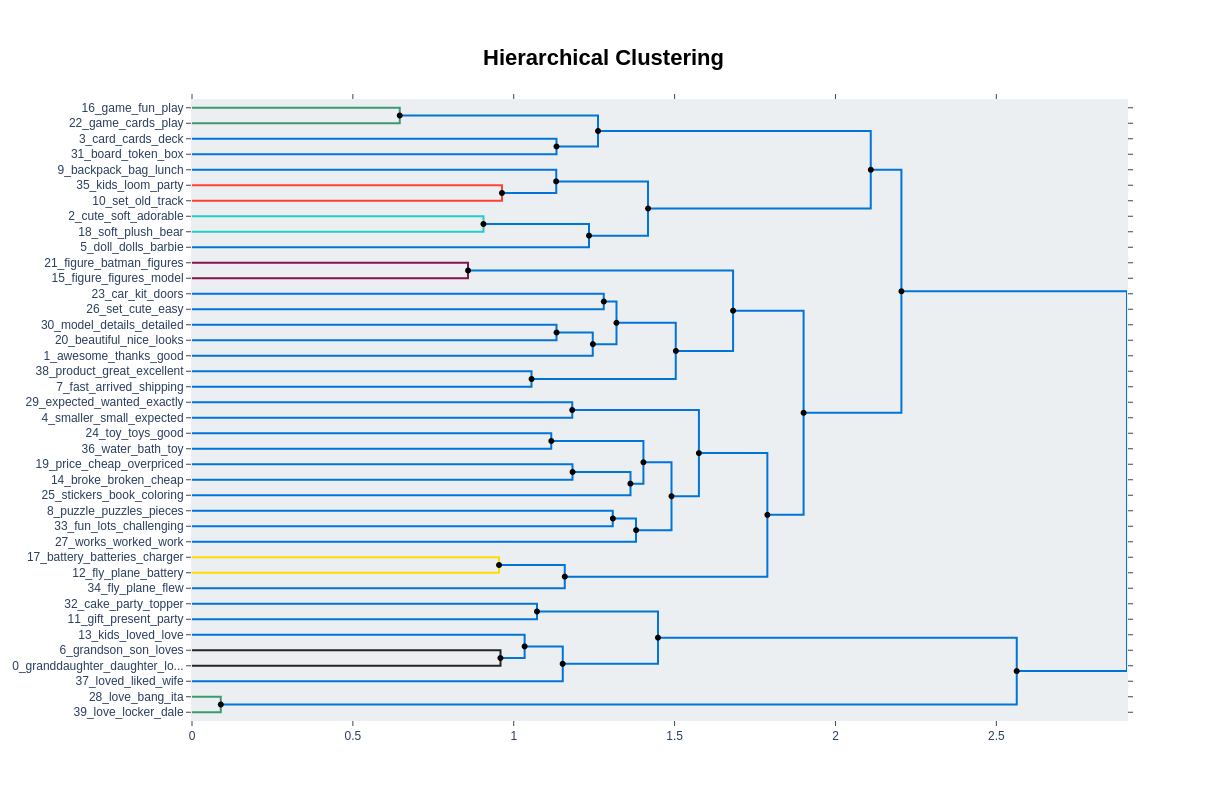

In [302]:
hierarchical_topics = topic_model.hierarchical_topics(docs)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [306]:
timestamps = relevant.DATETIME.tolist()
topics_over_time = topic_model.topics_over_time(docs, timestamps, nr_bins=20)

24it [00:02, 10.41it/s]


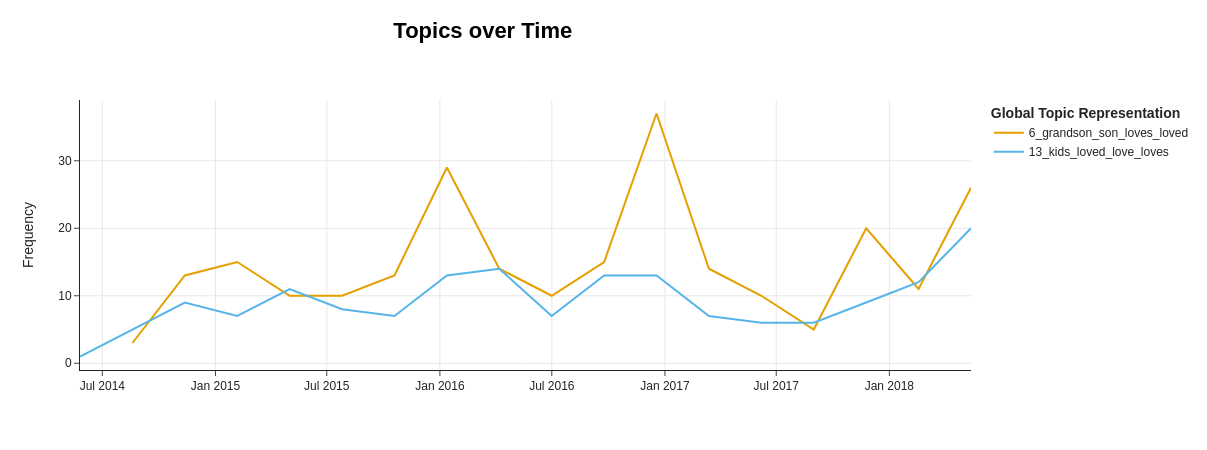

In [325]:
# topic_model.visualize_topics_over_time(topics_over_time, topics=[6, 7, 8, 14, 25])
topic_model.visualize_topics_over_time(topics_over_time, topics=[6, 13])

### TODO: Redo with final dataset

Let's look at a few topics to see if we can learn anything.

It looks like more reviews are being assigned to the "puzzles" topic as time goes on and the trend is fairly consistent with some seasonality. We should probably do a deeper dive on these reviews to understand if certain puzzles are particularly appealing or whether we should do seasonal marketing to drive more sales. Or, perhaps there was a problem with a popular product and we should ensure nothing was defective.

It also looks the number of reviews assigned to the stickers and coloring books topics was generally fairly consistent in 2015 and 2016, but starting in 2017 and 2018 more reviews started focusing on this topic. If we were doing this analysis in mid 2018, we'd want to explore further to potentially capitalize on or respond to this new trend of customers talking about puzzles and coloring books in their reviews.

We can also see that the general trend of reviews assigned the "broke, broken, cheap" topic is somewhat consistent over time. That's a good thing. If more reviews were focused on themes like broken, cheap, and other similar concepts, we might have a product quality or customer service problem.

It also looks like more reviews talk about grandchildren lovng gifts in November-January every year, but the topic of kids in general loving gifts is fairly stable. Given this pattern, we might want to explore some grandparent-specific marketing campaigns before the holiday season.

In [318]:
relevant["topic"] = topics

relevant.loc[relevant.topic == 25]

DATETIME  REVIEWER_NAME  \
649  2017-03-15      "C_Leigh"   
905  2017-11-21     "Danielle"   
906  2017-11-09  "Diane S. R."   
1036 2018-07-31        "David"   
1040 2018-03-18    "Steeljill"   
...         ...            ...   
8980 2018-07-18        "Grant"   
8981 2018-07-17   "HagermanRJ"   
8984 2018-06-26     "S. White"   
9115 2016-02-05   "OurReviews"   
9745 2016-01-09       "Jeremy"   

                                                SUMMARY STARS  \
649                              "Crayons  not Pencils"     4   
905                                       "Three Stars"     3   
906   "... Pony Board Books Set--2 Books by Hasbro a...     5   
1036                                "Ok but overpriced"     2   
1040                                              "Meh"     2   
...                                                 ...   ...   
8980  "wish I could have bought a much SMALLER box o...     3   
8981                                "great for parties"     5   
8984                                      "Three Stars"     3   
9115                                   "Great pencils."     5   
9745  "and I'm extremely disappointed that this is t...     2   

                                           REVIWER_TEXT VERIFIED  topic  
649   "I thought I was ordering pencils but they are...     true     25  
905   "Decent little board books, but I didn't recei...     true     25  
906   "My Little Pony Board Books Set--2 Books by Ha...     true     25  
1036  "Basically a coloring book with a paper potty ...     true     25  
1040  "Not that many stickers. And the activities in...     true     25  
...                                                 ...      ...    ...  
8980  "wish I could have bought a much SMALLER box o...     true     25  
8981     "Large box of cheap chalk, great for parties."     true     25  
8984  "Good chalk, but several pieces were broken in...     true     25  
9115  "The pencils are great. The notebook is okay, ...     true     25  
9745  "Why can't I buy refill markers only??  My kid...     true     25  

[73 rows x 7 columns]

# Save Topic Model for Potential Deployment

Lorem ipsum

It looks like this topic involving school backpacks and bag lunches is becoming less significant over time. We can use this information to 

In [168]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|██████████| 87/87 [00:00<00:00, 169.26it/s]


In [225]:
fig = topic_model.visualize_documents(docs, embeddings=embeddings)

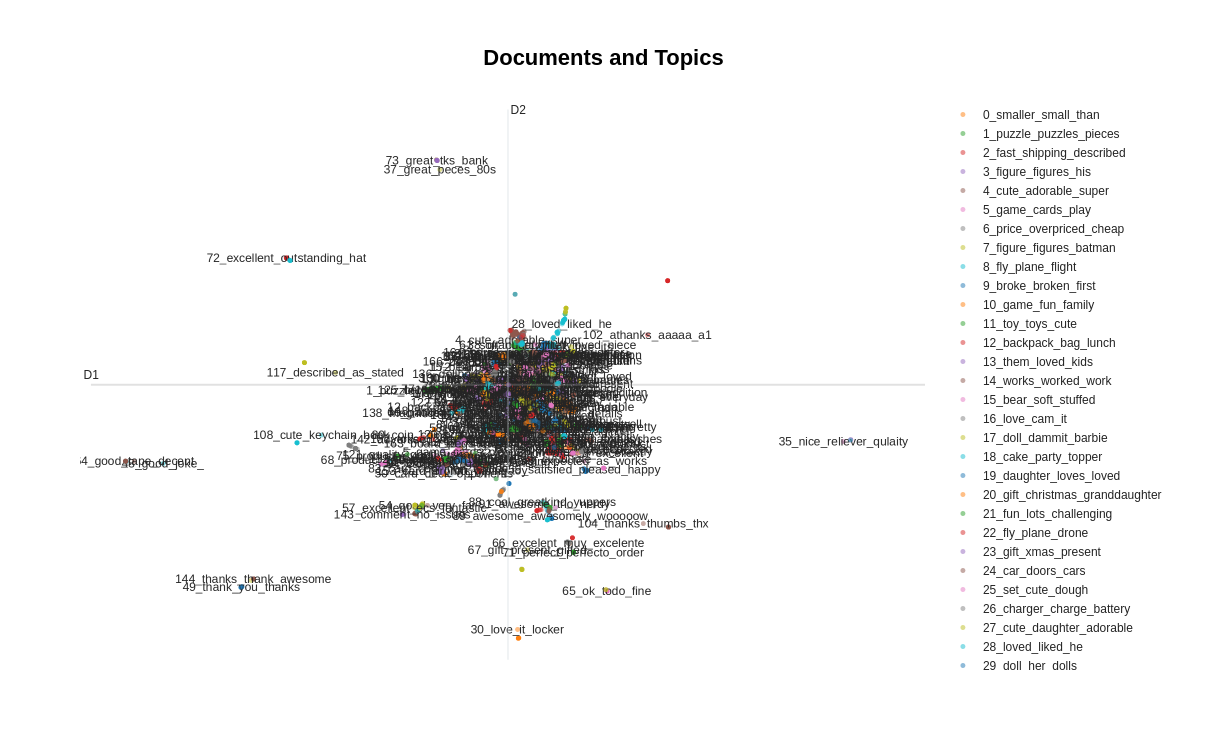

In [226]:
fig

# Scratch

In [ ]:
# import re
# import pandas as pd
# from bertopic import BERTopic

# # Prepare data
# trump = pd.read_csv('https://drive.google.com/uc?export=download&id=1xRKHaP-QwACMydlDnyFPEaFdtskJuBa6')
# trump.text = trump.apply(lambda row: re.sub(r"http\S+", "", row.text).lower(), 1)
# trump.text = trump.apply(lambda row: " ".join(filter(lambda x:x[0]!="@", row.text.split())), 1)
# trump.text = trump.apply(lambda row: " ".join(re.sub("[^a-zA-Z]+", " ", row.text).split()), 1)
# trump = trump.loc[(trump.isRetweet == "f") & (trump.text != ""), :]
# timestamps = trump.date.to_list()
# tweets = trump.text.to_list()

In [81]:
q = """
drop stage model_test;
"""
res = session.sql(q)
res.collect()

[Row(status='MODEL_TEST successfully dropped.')]

In [78]:
q = """
cre/rapids/notebooks/topic-modeling/ts model_test;
"""
res = session.sql(q)
res.collect()

q = """
put file:///rapids/notebooks/topic-modeling/fine-tuned-model.tar @model_test
    overwrite=true
    source_compression=none
    auto_compress=false
;
"""
res = session.sql(q)
res.collect()

[Row(source='fine-tuned-model.tar', target='fine-tuned-model.tar', source_size=405000679, target_size=405000688, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

In [79]:
!mkdir -p /rapids/notebooks/topic-modeling/model-testing/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [80]:
q = """
get @model_test file:///rapids/notebooks/topic-modeling/model-testing/
"""
res = session.sql(q)
res.collect()

[Row(file='fine-tuned-model.tar', size=405000679, status='DOWNLOADED', message=''),
 Row(file='fine-tuned-model.tar.gz', size=405111964, status='DOWNLOADED', message='')]

In [69]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('/rapids/notebooks/fine-tuned-model.tar.gz')

No sentence-transformers model found with name /rapids/notebooks/fine-tuned-model.tar.gz. Creating a new one with MEAN pooling.


OSError: It looks like the config file at '/rapids/notebooks/fine-tuned-model.tar.gz' is not a valid JSON file.

In [57]:
# load model. use model
# assume we have embeddings in a snowflake table. temporarily, i'll just generate them on the fly.

In [48]:
import numpy as np

np.save("embeddings", model.encode(["Adorable book for a child 9 months to 3"]))

In [49]:
SELECT COL
FROM TABLE

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
total 560
-rw-rw-r-- 1 1000 1000    268 May 19 16:59 Dockerfile
-rw-r--r-- 1 root root    132 May 19 17:14 config.json
-rw-r--r-- 1 root root 290081 May 19 17:48 create-model.ipynb
-rw-r--r-- 1 root root   3200 May 19 17:49 embeddings.npy
-rw-r--r-- 1 root root   3200 May 19 17:49 embeddings.npz.npy
drwxr-xr-x 5 root root   4096 May 19 17:44 fine-tuned-model.model
-rw-rw-r-- 1 1000 1000 259866 May 19 17:07 sbert-fine-tune.ipynb


In [31]:
ls fine-tuned-model.model/

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
1_Pooling/    config_sentence_transformers.json  special_tokens_map.json
2_Normalize/  modules.json                       tokenizer.json
README.md     pytorch_model.bin                  tokenizer_config.json
config.json   sentence_bert_config.json          vocab.txt
